# Loading code and data

## When loading notebook for the first time:

In [25]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1]:
!mkdir /root/.kaggle

In [2]:
########################################
########## Add kaggle API key ##########
########################################

!echo '{"username":"aliceallafort","key":"0d34479935dac419278ed5dce8d32974"}' > ~/.kaggle/kaggle.json

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!git clone https://github.com/TigerManon/drive-on-mars.git

Cloning into 'drive-on-mars'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 241 (delta 46), reused 65 (delta 33), pack-reused 144
Receiving objects: 100% (241/241), 25.85 MiB | 23.30 MiB/s, done.
Resolving deltas: 100% (91/91), done.


In [5]:
%cd drive-on-mars/
%mkdir raw_data
%cd raw_data

/content/drive-on-mars
/content/drive-on-mars/raw_data


In [6]:
!kaggle datasets download yash92328/ai4mars-terrainaware-autonomous-driving-on-mars

100% 5.72G/5.72G [04:51<00:00, 23.1MB/s]
100% 5.72G/5.72G [04:51<00:00, 21.1MB/s]


In [7]:
!unzip -q ai4mars-terrainaware-autonomous-driving-on-mars.zip



In [8]:
!rm ai4mars-terrainaware-autonomous-driving-on-mars.zip

In [9]:
%cd ../

/content/drive-on-mars


In [10]:
%ls



 dockerfile       Jinjin_draft.ipynb   README.md         'U-Net pretrained.ipynb'
 drive_on_mars/   notebooks/           requirements.txt  'U-Net Test-Copy1.ipynb'
 First_model.h5   raw_data/            setup.py           Untitled.ipynb


## When reloading the notebook

In [ ]:
%ls

In [ ]:
%pwd

'/content'

In [ ]:
%cd drive-on-mars/

/content/drive-on-mars


sample_data/


# Loading Libraries


In [11]:
#!pip install git+https://github.com/qubvel/segmentation_models
!pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00


In [12]:
# Data Visualisation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from tqdm import tqdm


from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split


In [13]:
# Segmentation Models

############# Alice #################
# Had to add this to make sm work in colab
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm
#####################################

import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models.losses import CategoricalFocalLoss, DiceLoss


from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf


Segmentation Models: using `tf.keras` framework.


# ResNet Backbone Model Tuning


## Data Generator for ResNet Backbone Model

In [ ]:
#image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
#label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [ ]:
# 0 - soil
# 1 - bedrock
# 2 - sand
# 3 - big rock
# 255 -> 4 - NULL (no label)

In [14]:
# image and label directories paths

image_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/images/edr"
label_folder = "raw_data/ai4mars-dataset-merged-0.1/msl/labels/train"

In [15]:
# Define a customized data generator
class UnetDataGenerator(keras.utils.Sequence):
    def __init__(self, image_folder, label_folder, input_shape, batch_size, num_classes, subfolder, split_percent, use_mask = False):
        self.image_folder       = image_folder
        self.label_folder       = label_folder
        self.input_shape        = input_shape
        self.batch_size         = batch_size
        self.num_classes        = num_classes
        self.subfolder          = subfolder
        self.split_percent      = split_percent
        self.path_df            = self.make_df()
        self.split_df()
        self.use_mask           = use_mask

    def __len__(self):
        print("Length of generator:", len(self.path_df))
        return math.ceil(len(self.path_df) / float(self.batch_size))

    def make_df(self):
        img_list = [f for f in os.listdir(self.image_folder) if f.endswith('.JPG')]
        lab_list = [f for f in os.listdir(self.label_folder) if f.endswith('.png')]

        path_df = pd.DataFrame(columns=["image_path", "label_path", "rover_mask_path", "range_mask_path"])

        for label_name in lab_list:
            image_name = label_name.replace('.png', '.JPG')
            rover_mask_name = label_name.replace('EDR', 'MXY')
            range_mask_name = label_name.replace('EDR', 'RNG')

            parent_folder = os.path.dirname(self.image_folder)
            rover_mask_path = os.path.join(parent_folder,'mxy', rover_mask_name)
            range_mask_path = os.path.join(parent_folder,'rng-30m', range_mask_name)

            if image_name in img_list and os.path.exists(rover_mask_path) and os.path.exists(range_mask_path):
                new_row = pd.DataFrame([{
                "image_path": os.path.join(self.image_folder, image_name),
                "label_path": os.path.join(self.label_folder, label_name),
                "rover_mask_path": rover_mask_path,
                "range_mask_path": range_mask_path
                }])
                path_df = pd.concat([path_df, new_row], ignore_index=True)

        return path_df



    def split_df(self):
        if self.subfolder == "train":
            self.path_df = self.path_df.iloc[:int(len(self.path_df) * self.split_percent)]
        elif self.subfolder == "val":
            self.path_df = self.path_df.iloc[int(len(self.path_df) * self.split_percent):]


    def __getitem__(self, index):
        input_images  = []
        output_targets = []

        #-------------------------------#
        #   Calculate start indice and end indice of the batch
        #-------------------------------#
        start = index * self.batch_size
        end = min((index + 1) * self.batch_size, len(self.path_df)) # Make sure that we can load all the data of the last batch

        for i in range(start, end):

            #-------------------------------#
            #   Get image,label,rover mask and range mask path of each batch from path_df
            #-------------------------------#
            jpg = self.path_df.iloc[i]["image_path"]
            png = self.path_df.iloc[i]["label_path"]
            rover = self.path_df.iloc[i]["rover_mask_path"]
            rng = self.path_df.iloc[i]["range_mask_path"]

            #-------------------------------#
            #   Load both range and rover masks combined
            #-------------------------------#
            rover_array = cv2.imread(rover)
            rng_array = cv2.imread(rng)
            # reversing mask to only keep the image out of the mask
            mask_combined = (1-rover_array) * (1-rng_array)

            #-------------------------------#
            #   Transform images and labels to numpy array, resize them
            #   Set the background label to 4
            #-------------------------------#

            jpg = cv2.imread(jpg)
            if self.use_mask:
                jpg = jpg * mask_combined

            png = cv2.imread(png,0)

            jpg = cv2.resize(jpg, dsize = (int(self.input_shape[0]), int(self.input_shape[1])))
            png = cv2.resize(png, dsize = (int(self.input_shape[0]), int(self.input_shape[1])),
                                      interpolation = cv2.INTER_NEAREST)

            png[png == 255] = 4

            #-------------------------------------------------------#
            #   One hot encode the labels
            #-------------------------------------------------------#

            seg_labels = np.eye(self.num_classes)[png.reshape([-1])]
            seg_labels = seg_labels.reshape((int(self.input_shape[0]), int(self.input_shape[1]), self.num_classes))

            input_images.append(jpg)
            output_targets.append(seg_labels)

        input_images = np.asarray(input_images)
        output_targets = np.array(output_targets)


        return input_images, output_targets

In [16]:
# Some inputs
batch_size = 16
num_classes = 5
input_shape = (256,256,3)
split_percent = 0.8
height=input_shape[0]
width=input_shape[1]
channels=input_shape[2]

In [17]:
%%time
# Train dataset generator and validation dataset generator
traingen = UnetDataGenerator(image_folder,
                             label_folder,
                             input_shape,
                             batch_size,
                             num_classes,
                             "train",
                             split_percent,
                            use_mask = True)

valgen = UnetDataGenerator(image_folder,
                           label_folder,
                           input_shape,
                           batch_size,
                           num_classes,
                           "val",
                           split_percent,
                          use_mask = True)

CPU times: user 33.6 s, sys: 605 ms, total: 34.2 s
Wall time: 34.1 s


## ResNet Backbone Model Initialization

In [19]:
#%% pre-trained model

# backbone choices: resnet34' resnet50' resnet101'
BACKBONE = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define model
# encoder_freeze=True (encoder_freeze: if ``True`` set all layers of encoder (backbone model) as non-trainable, default value is False.)
# input_shape: shape of input data/image ``(H, W, C)``, in general case you do not need to set ``H`` and ``W`` shapes, just pass ``(None, None, C)`` to make your model be able to process images af any size, but ``H`` and ``W`` of input images should be divisible by factor ``32``.
# decoder_filters=(256, 128, 64, 32, 16)
# input_shape=(None, None, 3)
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=num_classes, activation='softmax', encoder_freeze=True)

model_resnet_backbone.summary()

94592056/94592056 [==============================] - 2s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_35 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                           

In [20]:
# compile model with defined optimozer, loss and metrics

# loss: dice_loss
categorical_focal_loss = CategoricalFocalLoss()
dice_loss = DiceLoss()
categorical_focal_dice_loss = categorical_focal_loss + dice_loss
# categorical_focal_jaccard_loss = categorical_focal_loss + jaccard_loss
# iou_score = IOUScore() (threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round, as: metrics = [sm.metrics.IOUScore(threshold=0.5)])

metrics=['accuracy', iou_score]

model_resnet_backbone.compile(optimizer='adam',loss=categorical_focal_dice_loss, metrics=metrics)

## ResNet Backbone Model Training

In [21]:
%%time
MODEL = "Unet_Res50_Unfreeze_ImageNet_WithMasks_256pix"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL),
                                            monitor="val_iou_score",
                                            save_best_only = False)

LR_reducer = callbacks.ReduceLROnPlateau(patience = 3,
                                         monitor="val_iou_score",
                                         factor = 0.1,
                                         min_lr = 0
                                        )

early_stopper = callbacks.EarlyStopping(patience = 5,
                                        monitor="val_iou_score",
                                        restore_best_weights=True)



history_res_backbone = model_resnet_backbone.fit(traingen,
          validation_data=valgen,
          epochs=100,
          callbacks = [modelCheckpoint, LR_reducer, early_stopper],
          verbose=1)


Length of generator: 3213
Length of generator: 12850
Length of generator: 12850
Epoch 1/100
Length of generator: 12850
804/804 [==============================] - ETA: 0s - loss: 0.3658 - accuracy: 0.8345 - iou_score: 0.5541Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
Length of generator: 3213


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


804/804 [==============================] - 478s 554ms/step - loss: 0.3658 - accuracy: 0.8345 - iou_score: 0.5541 - val_loss: 0.3753 - val_accuracy: 0.8400 - val_iou_score: 0.5465 - lr: 0.0010
Length of generator: 12850
Epoch 2/100
Length of generator: 12850
804/804 [==============================] - ETA: 0s - loss: 0.3012 - accuracy: 0.8614 - iou_score: 0.6167Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 440s 548ms/step - loss: 0.3012 - accuracy: 0.8614 - iou_score: 0.6167 - val_loss: 0.3129 - val_accuracy: 0.8578 - val_iou_score: 0.6053 - lr: 0.0010
Length of generator: 12850
Epoch 3/100
Length of generator: 12850
804/804 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8700 - iou_score: 0.6361Length of generator: 3213
Length of generator: 3213
Length of generator: 3213
804/804 [==============================] - 437s 544ms/step - loss: 0.2819 - accuracy: 0.8700 - iou_score: 0.6361 - val_l

In [22]:
history_res_backbone.history

{'loss': [0.3657638430595398,
  0.30124253034591675,
  0.28193238377571106,
  0.2677738666534424,
  0.24144408106803894,
  0.23225967586040497],
 'accuracy': [0.834498405456543,
  0.8613685369491577,
  0.8700071573257446,
  0.8770703077316284,
  0.8875969052314758,
  0.8907396197319031],
 'iou_score': [0.5540653467178345,
  0.6167463064193726,
  0.6361489295959473,
  0.6515443921089172,
  0.6790785193443298,
  0.6893125176429749],
 'val_loss': [0.37528297305107117,
  0.3129326403141022,
  0.2939271628856659,
  0.2871421277523041,
  0.2697006165981293,
  0.26730599999427795],
 'val_accuracy': [0.8399618268013,
  0.8577547669410706,
  0.8726794123649597,
  0.8784911632537842,
  0.8845313787460327,
  0.8852259516716003],
 'val_iou_score': [0.5464835166931152,
  0.6052890419960022,
  0.6307273507118225,
  0.6352460980415344,
  0.654553234577179,
  0.6564145088195801],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}

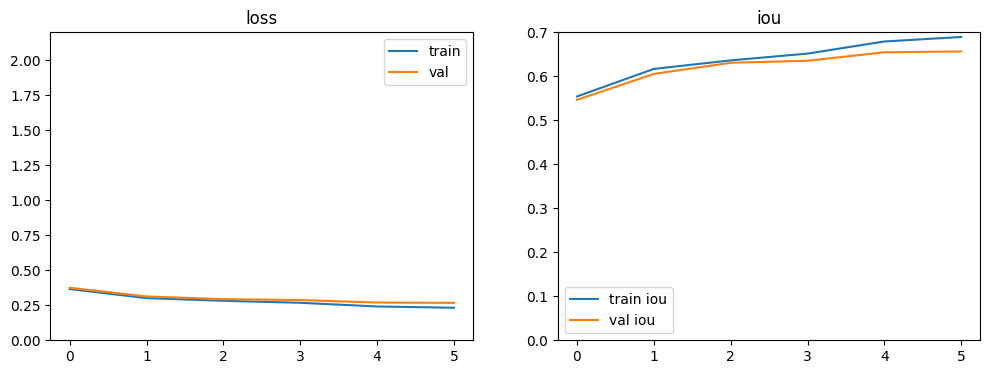

In [23]:
def plot_history(history_res_backbone, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history_res_backbone.history['loss'], label = 'train' + exp_name)
    ax1.plot(history_res_backbone.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history_res_backbone.history['iou_score'], label='train iou'  + exp_name)
    ax2.plot(history_res_backbone.history['val_iou_score'], label='val iou'  + exp_name)
    ax2.set_ylim(0, 0.7)
    ax2.set_title('iou')
    ax2.legend()
    plt.show()

plot_history(history_res_backbone)

## Model Saving

In [24]:
!mkdir raw_data/models
!ls raw_data

ai4mars-dataset-merged-0.1  models


In [26]:
model_resnet_backbone.save(f'raw_data/models/{MODEL}.h5')

In [27]:
!ls raw_data/models

Unet_Res50_Unfreeze_ImageNet_WithMasks_256pix.h5


In [28]:

%cp raw_data/models/"Unet_Res50_Unfreeze_ImageNet_WithMasks_256pix".h5 /content/drive/MyDrive/data/models

## Training Records

09/12/2023 23:34




*   Model: unet_4deep_16in_256pix
*   optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
    iou_score
*   Trainable params: 1941173
*   Data: 12851 train images; 3213 val images, loaded,preporcessed,splited by   
      UnetDataGenerator
*   Training: set up for 100 epochs, stopped at 6 epochs by early stopping,
    Wall time: 29min 52s, GPU V100
*   'loss': 0.5861780643463135,
    'iou_score': 0.5779913663864136,
    'val_loss':  0.5868656635284424],
    'val_iou_score': 0.5775318145751953,
    'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]





10/12/2023 03:34

* Model: unet_4deep_16in_1024pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics.
  iou_score
* Trainable params: 1941173
* Data: image and label size: 1024, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator
* Training: set up for 100 epochs, stopped at 6 epochs by early stopping,        Wall time: 2h 8min 6s, GPU V100
* 'loss':  0.6727234125137329, 'iou_score': 0.50568687915802, 'val_loss': 0.6704270839691162, 'val_iou_score': 0.5068952441215515, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]




10/12/2023 10:34

* Model: unet_4deep_64in_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Trainable params: 31032005

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 29min 3s, GPU A100

* 'loss': 0.5815900564193726, 'iou_score': 0.580341637134552, 'val_loss': 0.59281826019287112, 'val_iou_score': 0.5689619183540344, 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005] Slightly overfitted

10/12/2023 16:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss: sm.losses.bce_jaccard_loss, metrics: sm.metrics. iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 27min 3s, GPU A100

* 'loss': 0.4621942937374115
 'accuracy': 0.8795599341392517
 'iou_score': 0.659989595413208
 'val_loss': 0.48931652307510376
 'val_accuracy':  0.8699352741241455
 'val_iou_score': 0.6389757394790649
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]}


10/12/2023 18:34

* Model: Unet_ResBackBone_ImageNet_img_256pix

* optimizer: 'adam', loss:'categorical_crossentropy', metrics: accuracy, iou_score

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss': 0.28132763504981995
 'accuracy': 0.8859129548072815
 'iou_score': 0.5797572731971741
 'val_loss': 0.31182384490966797
 'val_accuracy':  0.8733996152877808
 'val_iou_score': 0.5677776336669922
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]


11/12/2023 18:34

* Model:Unet_Res34_ImageNet_img_256pix

* optimizer: 'adam', loss:categorical_focal_dice_loss = categorical_focal_loss + dice_loss, metrics: metrics=['accuracy', iou_score],metrics=['accuracy', iou_score]

* Total params: 24456734 (93.30 MB)
Trainable params: 24439384 (93.23 MB)
Non-trainable params: 17350 (67.77 KB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss':  0.2820780277252197
 'accuracy': 0.8596312403678894
 'iou_score': 0.6308621168136597
 'val_loss': 0.2873755097389221
 'val_accuracy':  0.8627598285675049
 'val_iou_score': 0.6269094347953796
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]


11/12/2023 22:34

* Model:Unet_Res34_Unfreeze_ImageNet_img_256pix

* optimizer: 'adam', loss:categorical_focal_dice_loss = categorical_focal_loss + dice_loss, metrics: metrics=['accuracy', iou_score],metrics=['accuracy', iou_score]

* Weights ImageNet unfrozen
Total params: 24456734 (93.30 MB)
Trainable params: 3167640 (12.08 MB)
Non-trainable params: 21289094 (81.21 MB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss':
  0.2606087327003479
 'accuracy':
  0.8644973635673523
 'iou_score':
  0.6521452069282532
 'val_loss':
  0.28726834058761597
 'val_accuracy':
  0.8619291186332703
 'val_iou_score':
  0.6286683082580566
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]






11/12/2023 23:34

* Model:Unet_Res50_Unfreeze_ImageNet_img_256pix

* optimizer: 'adam', loss:categorical_focal_dice_loss = categorical_focal_loss + dice_loss, metrics: metrics=['accuracy', iou_score],metrics=['accuracy', iou_score]

* Weights ImageNet unfrozen ResNet 50
Total params: 32561694 (124.21 MB)
Trainable params: 9059224 (34.56 MB)
Non-trainable params: 23502470 (89.65 MB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

* 'loss':
  0.2562115490436554
 'accuracy':
  0.8671656847000122
 'iou_score':
  0.6576858162879944
 'val_loss':
  0.27280107140541077
 'val_accuracy':
  0.8671523928642273
 'val_iou_score':
  0.6417083144187927
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]



12/12/2023 10:10

* Model:Unet_Res101_Unfreeze_ImageNet_img_256pix

* optimizer: 'adam', loss:categorical_focal_dice_loss = categorical_focal_loss + dice_loss, metrics: metrics=['accuracy', iou_score],metrics=['accuracy', iou_score]

* Weights ImageNet unfrozen ResNet 101
Total params: 51606046 (196.86 MB)
Trainable params: 9111448 (34.76 MB)
Non-trainable params: 42494598 (162.10 MB)

* Data: image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 30min, GPU A100

*  'loss':
  0.25483718514442444
 'accuracy':
  0.8705011606216431
 'iou_score':
  0.6602714657783508
 'val_loss':
  0.2740992307662964
 'val_accuracy':
  0.8686534762382507
 'val_iou_score':
  0.642823338508606
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]








12/12/2023 21:10

* Model:Unet_Res50_Unfreeze_ImageNet_WithMasks_256pix

* optimizer: 'adam', loss:categorical_focal_dice_loss = categorical_focal_loss + dice_loss, metrics: metrics=['accuracy', iou_score],metrics=['accuracy', iou_score]

* Weights ImageNet unfrozen ResNet 50
Total params: 32561694 (124.21 MB)
Trainable params: 9059224 (34.56 MB)
Non-trainable params: 23502470 (89.65 MB)

* Data: images overlapped with rover and 30 range masks. Image and label size: 256, 12851 train images; 3213 val images, loaded, preporcessed,splited by UnetDataGenerator

* Training: set up for 100 epochs, stopped at 6 epochs by early stopping, Wall time: 44min 24s, GPU A100

*   'loss':
  0.23225967586040497
 'accuracy':
  0.8907396197319031
 'iou_score':
  0.6893125176429749
 'val_loss':
  0.26730599999427795
 'val_accuracy':
  0.8852259516716003
 'val_iou_score':
  0.6564145088195801
 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005]




## Evaluate Model



## History

In [ ]:
# %%time
# es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
# #modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


# history = model.fit(X_train, y_train,
#           batch_size=16,
#           epochs=10,
#           validation_split=0.3,
#           callbacks=[es],
#           verbose=1)


Epoch 1/10
16/16 [==============================] - 26s 1s/step - loss: 1.4578 - iou_score: 0.0815 - val_loss: 1.2656 - val_iou_score: 0.0958
Epoch 2/10
16/16 [==============================] - 23s 1s/step - loss: 1.2874 - iou_score: 0.1014 - val_loss: 1.2581 - val_iou_score: 0.0978
Epoch 3/10
16/16 [==============================] - 24s 2s/step - loss: 1.2503 - iou_score: 0.1036 - val_loss: 1.2078 - val_iou_score: 0.1063
Epoch 4/10
16/16 [==============================] - 24s 2s/step - loss: 1.2265 - iou_score: 0.1115 - val_loss: 1.1993 - val_iou_score: 0.1112
Epoch 5/10
16/16 [==============================] - 24s 2s/step - loss: 1.2203 - iou_score: 0.1126 - val_loss: 1.2105 - val_iou_score: 0.1098
Epoch 6/10
16/16 [==============================] - 24s 1s/step - loss: 1.2093 - iou_score: 0.1202 - val_loss: 1.1699 - val_iou_score: 0.1257
Epoch 7/10
16/16 [==============================] - 24s 2s/step - loss: 1.1916 - iou_score: 0.1295 - val_loss: 1.1409 - val_iou_score: 0.1381
Epoch 

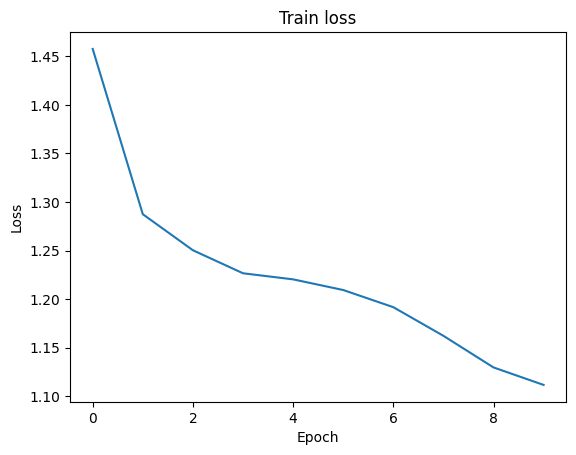

In [ ]:
# plot_history(history)

In [ ]:
%%time
es = callbacks.EarlyStopping(patience=2,restore_best_weights=True)
#modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format('First_model'), monitor="val_loss", verbose=0, save_best_only=False)


history = model.fit(X_train, y_train,
          batch_size=16,
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=1)

Epoch 1/100
16/16 [==============================] - 24s 1s/step - loss: 1.1298 - iou_score: 0.1686 - val_loss: 1.1122 - val_iou_score: 0.1594
Epoch 2/100
16/16 [==============================] - 21s 1s/step - loss: 1.0876 - iou_score: 0.1826 - val_loss: 1.1037 - val_iou_score: 0.1642
Epoch 3/100
16/16 [==============================] - 21s 1s/step - loss: 1.0782 - iou_score: 0.1859 - val_loss: 1.1144 - val_iou_score: 0.1632
Epoch 4/100
16/16 [==============================] - 22s 1s/step - loss: 1.0691 - iou_score: 0.1947 - val_loss: 1.1006 - val_iou_score: 0.1652
Epoch 5/100
16/16 [==============================] - 22s 1s/step - loss: 1.0615 - iou_score: 0.1987 - val_loss: 1.0589 - val_iou_score: 0.1860
Epoch 6/100
16/16 [==============================] - 22s 1s/step - loss: 1.0442 - iou_score: 0.2079 - val_loss: 1.0723 - val_iou_score: 0.1840
Epoch 7/100
16/16 [==============================] - 22s 1s/step - loss: 1.0355 - iou_score: 0.2171 - val_loss: 1.0453 - val_iou_score: 0.1932

In [ ]:
history.history

{'loss': [1.1297701597213745,
  1.0876463651657104,
  1.0782088041305542,
  1.0690951347351074,
  1.0615358352661133,
  1.0441967248916626,
  1.0354652404785156,
  1.0449689626693726,
  1.0198251008987427],
 'iou_score': [0.1685541868209839,
  0.18260574340820312,
  0.18585895001888275,
  0.19469091296195984,
  0.19866147637367249,
  0.20785057544708252,
  0.2171015739440918,
  0.2078864872455597,
  0.21589668095111847],
 'val_loss': [1.1121928691864014,
  1.1037356853485107,
  1.1143794059753418,
  1.1005871295928955,
  1.0588997602462769,
  1.0723048448562622,
  1.04526686668396,
  1.0609480142593384,
  1.080163836479187],
 'val_iou_score': [0.15940341353416443,
  0.1642206758260727,
  0.16320741176605225,
  0.16516396403312683,
  0.18596236407756805,
  0.18400494754314423,
  0.1931913048028946,
  0.1878410279750824,
  0.17755672335624695]}

<function matplotlib.pyplot.show(close=None, block=None)>

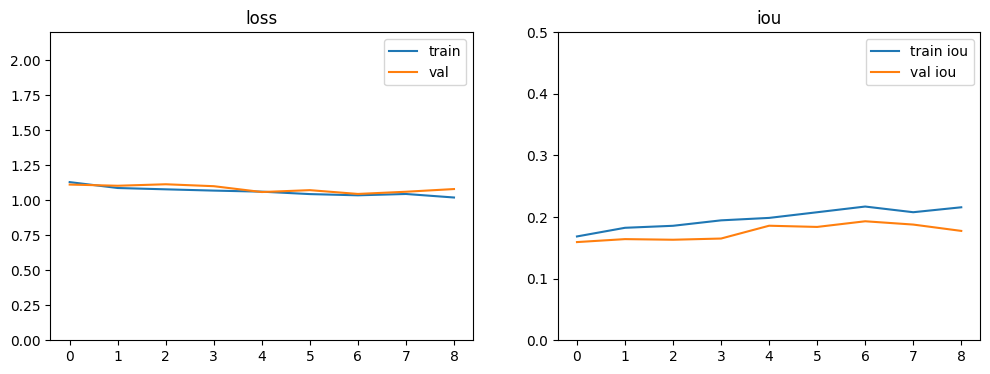

In [ ]:
# def plot_history(history, title='', axs=None, exp_name=""):
#     if axs is not None:
#         ax1, ax2 = axs
#     else:
#         f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#     if len(exp_name) > 0 and exp_name[0] != '_':
#         exp_name = '_' + exp_name
#     ax1.plot(history.history['loss'], label = 'train' + exp_name)
#     ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
#     ax1.set_ylim(0., 2.2)
#     ax1.set_title('loss')
#     ax1.legend()

#     ax2.plot(history.history['iou_score'], label='train iou'  + exp_name)
#     ax2.plot(history.history['val_iou_score'], label='val iou'  + exp_name)
#     ax2.set_ylim(0, 0.5)
#     ax2.set_title('iou')
#     ax2.legend()
#     return (ax1, ax2)

# plot_history(history)
# plt.show

In [ ]:
print(1)